## SpaGFT Tutorial：Visium Mouse Brain Coronal

### Outline
1. Import packages
<br />
<br />
2. Load data
<br />
<br />
3. QC and preprocessing
<br />
<br />
4. Function: identify spatially variable genes
<br />
<br />
5. Function: gene expression enhancement


The installation steps can be found [here](https://github.com/jxLiu-bio/SpaGFT). SpaGFT is a python package to analyze spatial transcriptomics data via graph Fourier transform. To install SpaGFT, the python version is required to be >= 3.7. You can check your python version by:

In [1]:
import platform
platform.python_version()

'3.8.0'

### 1. Import packages

In [2]:
import SpaGFT as spg
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import os


sc.settings.verbosity = 1
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')

scanpy==1.9.1 anndata==0.9.1 umap==0.5.3 numpy==1.21.5 scipy==1.8.0 pandas==1.4.2 scikit-learn==1.0.2 statsmodels==0.14.0 python-igraph==0.9.10 louvain==0.7.1 pynndescent==0.5.10


Define the folder to save the results which are generated from the following analysis:

In [3]:
results_folder = './results/mouse_brain_coronal_analysis/'
if not os.path.exists(results_folder):
    os.makedirs(results_folder)

### 2. Load data

In this tutorial, we use a Visium dataset of Mouse Brain. The dataset can be downloaded [here](https://drive.google.com/drive/folders/1-B9ipgx5gdWU-go38-acCdS9xHCK9D3E?usp=sharing). Two key elements are essential for running SpaGFT: the raw gene counts matrix and spatial coordinates of spots. Indeed, the basic object input to SpaGFT should be an anndata object which contains the above two elements.

In [4]:
adata = sc.read_visium("./data/mouse-he-coronal")
adata.var_names_make_unique()
# Add raw to anndata object
adata.raw = adata

You can also create your datasets which are ```anndata``` objects. Note that the raw count matrix should be found in adata.X, and the spatial coordinates of all spots should be found in ```adata.obs``` or ```adata.obsm```. You can use diverse functions provided by scanpy to create the anndata object. For example, you can read Visium datasets by
```Python
sc.read_visium() # recommend
```
Alternatively, users can also create the anndata object using the raw count matrix and spatial coordinates of spots in a direct way:
```Python
count_mtx = pd.read_csv(PATH_TO_COUNT_MATRIX)
coord_mtx = pd.read_csv(PATH_TO_COORDINATE_MATRIX)
count_mtx.iloc[:5, :5]
coord_mtx.iloc[:5, :5]
# create the anndata object
adata = sc.AnnData(count_mtx)
adata.obs.loc[:, ['x', 'y']] = coord_mtx
adata.var_names_make_unique()
adata.raw = adata
```
More approaches to load datasets can be found at [Scanpy](https://scanpy.readthedocs.io/en/stable/api.html#reading)


### 3. QC and preprocessing
Before the formal analysis, we perform some basic filtering of genes and normalize Visium counts data with the ```normalize_total``` method from Scanpy followed by log-transform.

In [5]:
# QC
sc.pp.filter_genes(adata, min_cells=10)
# Normalization
sc.pp.normalize_total(adata, inplace=True)
sc.pp.log1p(adata)

### 4. Function: identify spatially variable genes

#### 4.1 Determine the Fourier modes and identify SVGs

To begin with, determine the number of Fourier modes for detecting SVGs. SpaGFT provides the dermine_frequency_ratio function based on the kneedle algorithm to determine how many FMs used automatically.
Note that *ratio_low * $\sqrt{n}$* and *ratio_high * $\sqrt{n}$* are the recommended low-frequency and high-frequency FMs, where *$\sqrt{n}$* is the number of spots in the original dataset.

In [6]:
# determine the number of low-frequency FMs and high-frequency FMs
(ratio_low, ratio_high) = spg.gft.determine_frequency_ratio(adata,
                                                            ratio_neighbors=1)

Obatain the Laplacian matrix


In the following, SpaGFT will transform gene expression signals from the spatial domain to the frequency domain and analyze the frequency signals to identify SVGs.

In [7]:
# calculation
gene_df = spg.detect_svg(adata,
                         spatial_info=['array_row', 'array_col'],
                         ratio_low_freq=ratio_low,
                         ratio_high_freq=ratio_high,
                         ratio_neighbors=1,
                         filter_peaks=True,
                         S=6)
# S determines the  sensitivity of kneedle algorithm
# extract spaitally variable genes
svg_list = gene_df[gene_df.cutoff_gft_score][gene_df.qvalue < 0.05].index.tolist()
print("The number of SVGs: ", len(svg_list))
# the top 20 SVGs
print(svg_list[:20])

The precalculated low-frequency FMs are USED
The precalculated high-frequency FMs are USED
Graph Fourier Transform finished!
SVG ranking could be found in adata.var['svg_rank']
The spatially variable genes judged by gft_score could be found 
          in adata.var['cutoff_gft_score']
Gene signals in frequency domain when detect SVGs could be found
          in adata.varm['freq_domain_svg']
The number of SVGs:  2118
['Agt', 'Sparc', 'Epop', 'Nrgn', 'Mef2c', 'Camk2n1', 'Stx1a', 'Slc17a7', 'Kcnh3', 'Ngef', 'Igsf1', 'Dlk1', 'Ddn', 'Tcf7l2', 'Slc6a11', 'Arhgap36', 'Zfhx3', 'Itpka', 'Arpp19', 'Gpx3']


Detailly, spatially variable genes (SVGs) are genes that exhibit specific spatial patterns. SpaGFT will transform the gene expression signal from the spatial/vertex domain to the frequency/spectral domain and identify SVGs in the frequency domain. There are three key parameters:
+ *ratio_neighbors*, which determines the neighbors of a spot when construct the KNN graph. In SpaGFT, the top *ratio_neighbors* $\sqrt{n}$/2 nearest neighobors are used, where $n$ represents the number of spots.
+ *ratio_low_freq*, which determines the number of low-frequency Fourier modes (FMs) used to describe the gene expression signals. In SpaGFT, the top *ratio_low_freq* * $\sqrt{n}$ low-frequency Fourier modes will be utilized to describe gene expression signals, where $n$ represents the number of spots.

+ *ratio_high_freq*, which determines the number of high-frequency Fourier modes used, as the contrast to measure how high the contributions of low-frequency to recover the signals of genes. In SpaGFT, the top *ratio_high_freq* * $\sqrt{n}$ high-frequency Fourier modes will be utilized, where $n$ represents the number of spots.

#### 4.2 Visualize the identified SVGs

We will visualize several detected genes which exhibit diverse spatial patterns. This step can be achieved by ```sc.pl.spatial``` function provided by scanpy or our built-in ```scatter_gene``` function to visualize gene expression patterns.

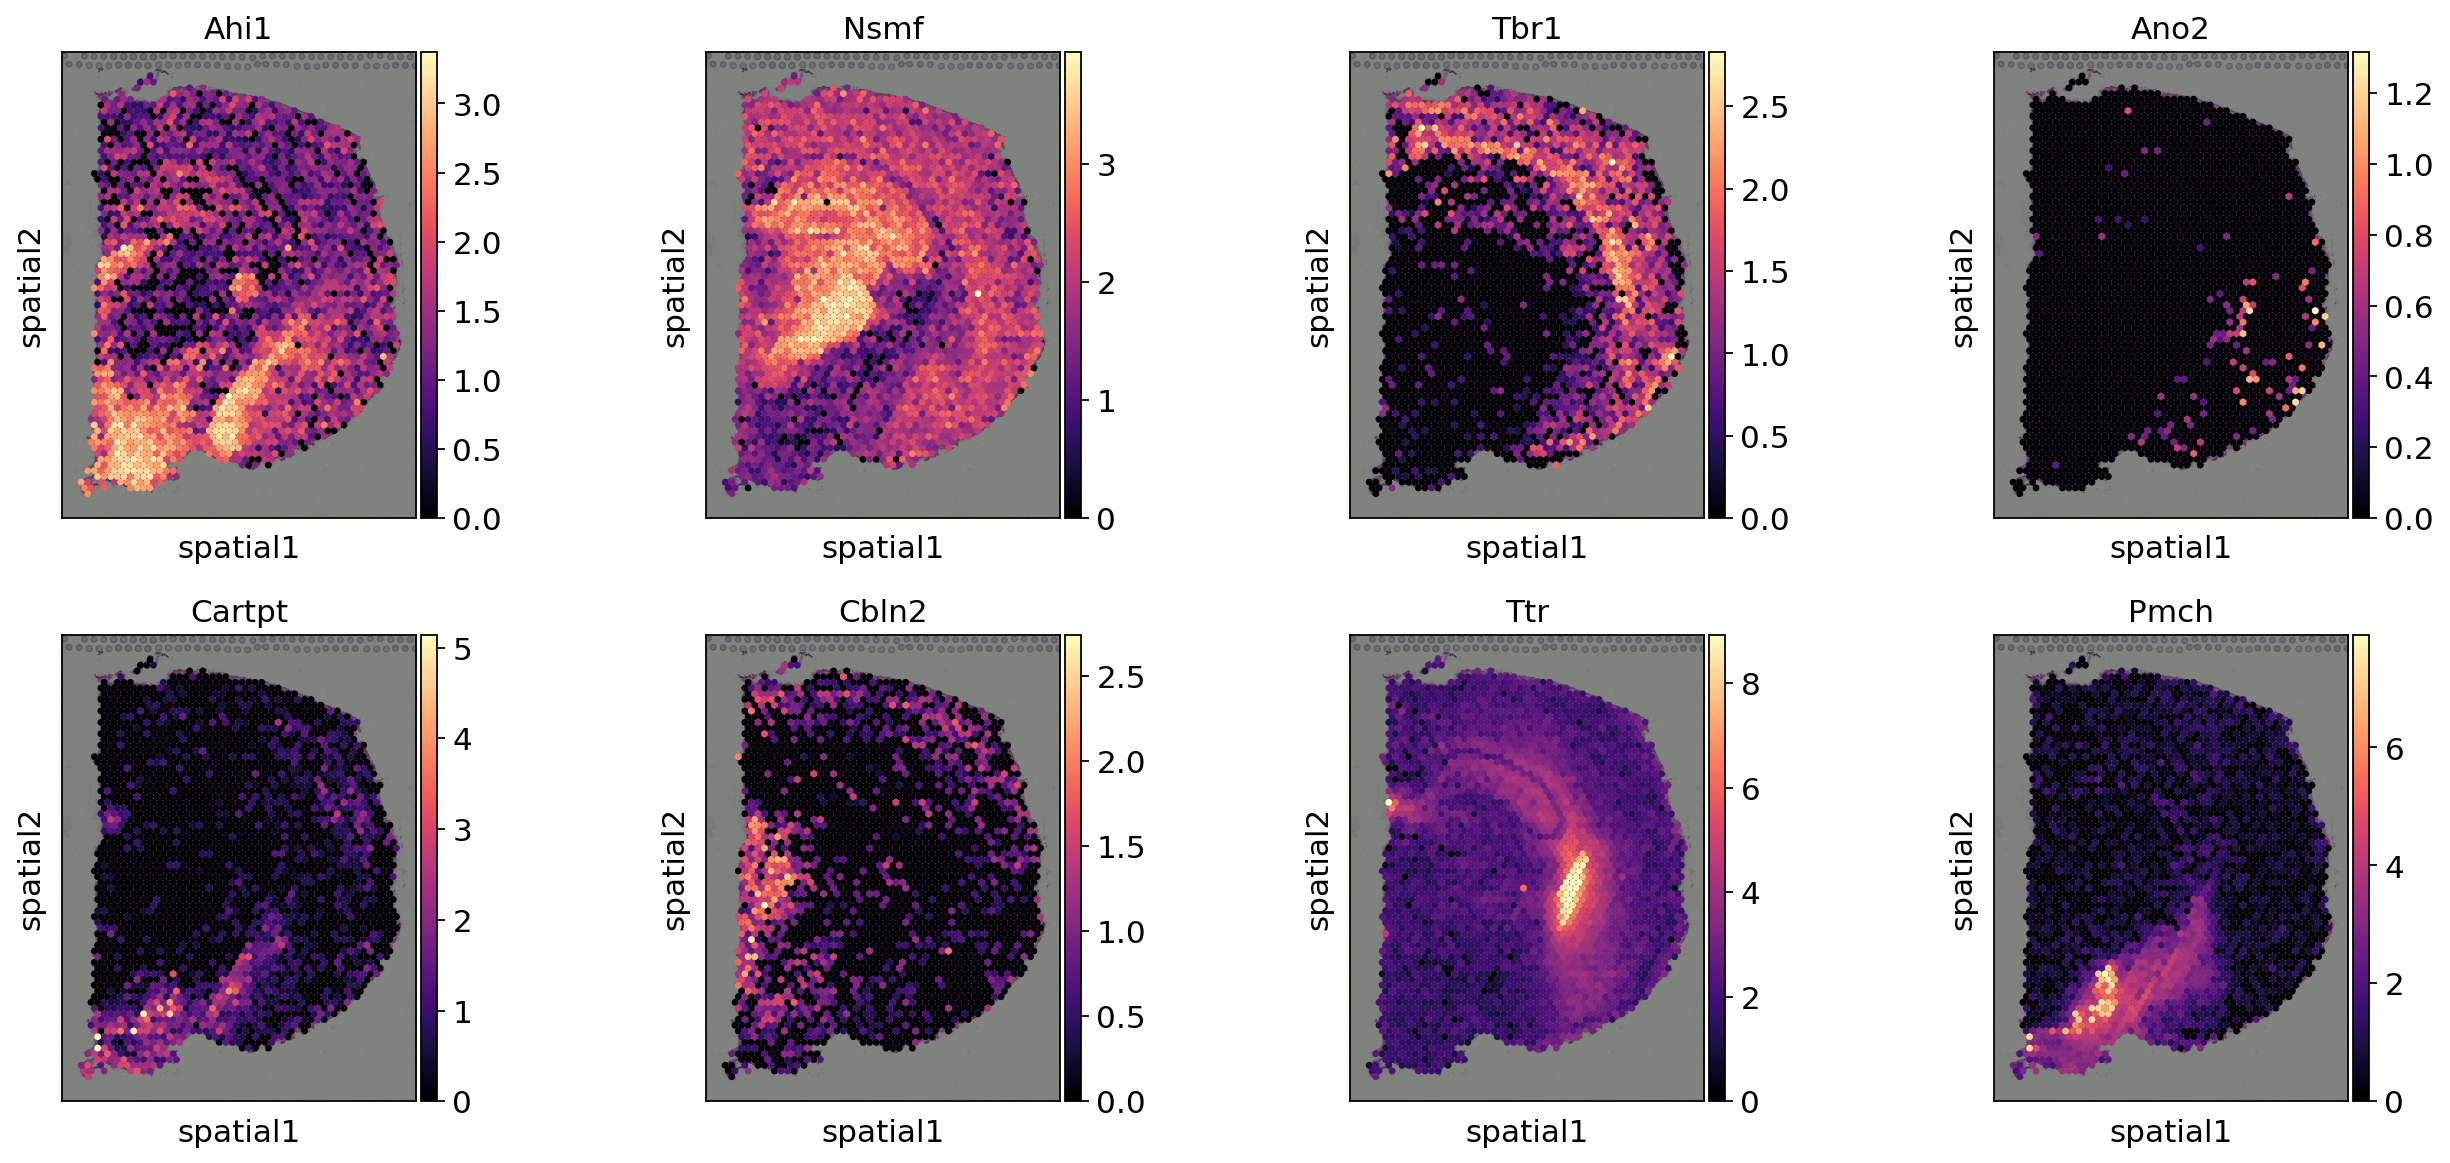

In [8]:
plot_svgs = ['Ahi1', 'Nsmf', 'Tbr1', 'Ano2', 'Cartpt', 'Cbln2', 'Ttr', 'Pmch']
sc.pl.spatial(adata, color=plot_svgs, size=1.6, cmap='magma', use_raw=False)

#### 4.3 Plot frequency signals

One of the characteristics of SpaGFT is that it can obtain new representations for genes in the frequency domain. In above genes' frequency signals can be found in ```adata.varm['freq_domain_svg']``` and visualized by

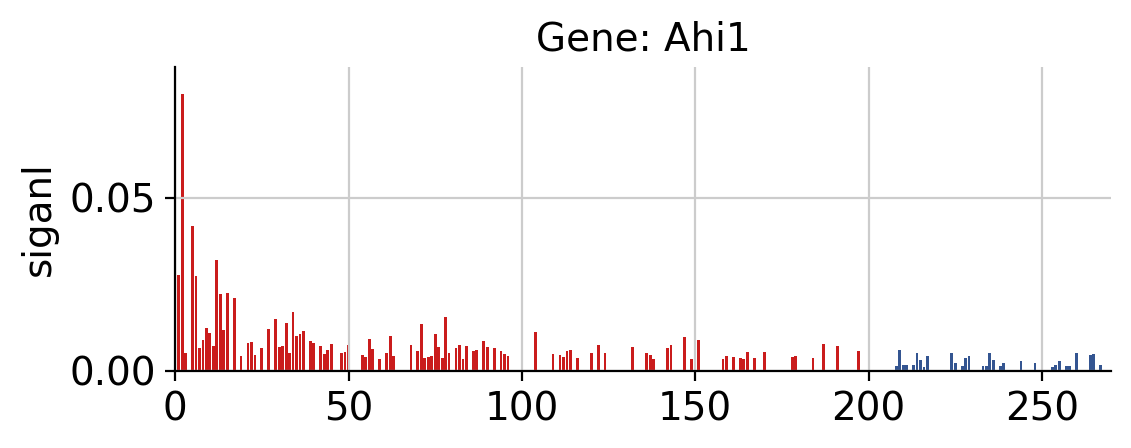

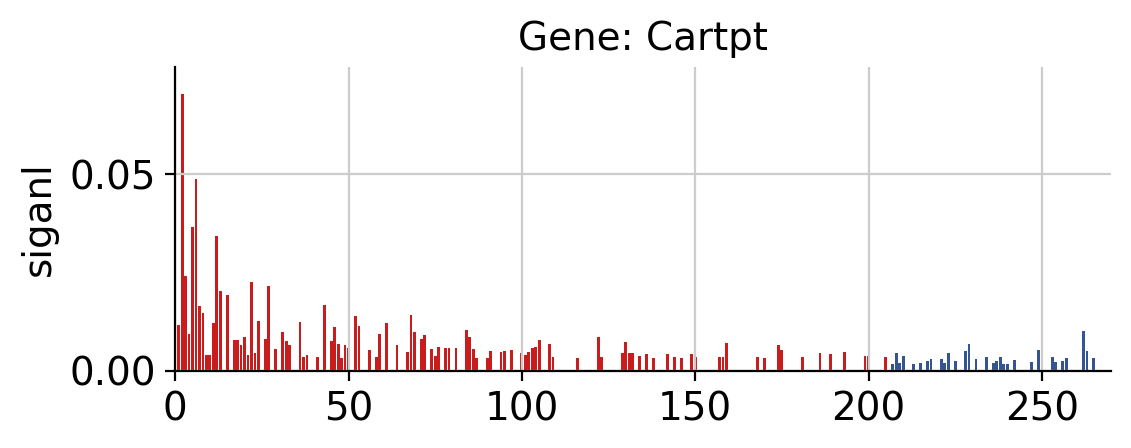

In [9]:
# use gene_freq_signal function to plot frequency signals
spg.plot.gene_freq_signal(adata, gene=plot_svgs[0])
spg.plot.gene_freq_signal(adata, gene=plot_svgs[4])

where the red signals correspond to low-frequency signals, while the blue signals correspond to high-frequency signals. 

#### 4.4 UMAP visualization of gene frequency signals

In addition, we can also separate SVGs and non-SVGs in the frequency domain. By projecting the frequency domain to 2-dimensional space by UMAP, we can verify this easily:

The umap coordinates of genes when identify SVGs could be found in 
          adata.varm['freq_umap_svg']


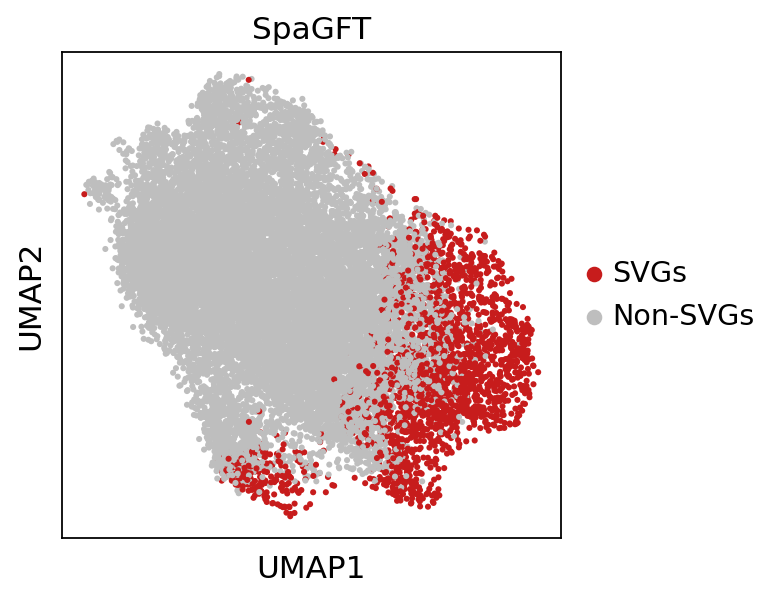

In [10]:
# gene umap
spg.plot.gene_signal_umap(adata, svg_list, size=30)
svg_umap_df = pd.DataFrame(adata.varm['freq_umap_svg'],
                           index=adata.var_names,
                           columns=['UMAP_1', 'UMAP_2'])

### 5 Function: gene expression enhancement

SRT expression data suffers from high noise, which will influence the credibility of analytical results. Therefore, SpaGFT adapts a low-pass filter to process signals in the frequency domain and performs inverse GFT to obtain enhanced signals. Note that this step is time-consuming and will take several minutes for Visium datasets.

In [11]:
# copy from the original dataset
new_adata = adata.copy()
new_adata = spg.low_pass_enhancement(new_adata,
                                     inplace=True,
                                     c=0.01,
                                     ratio_low_freq=15)

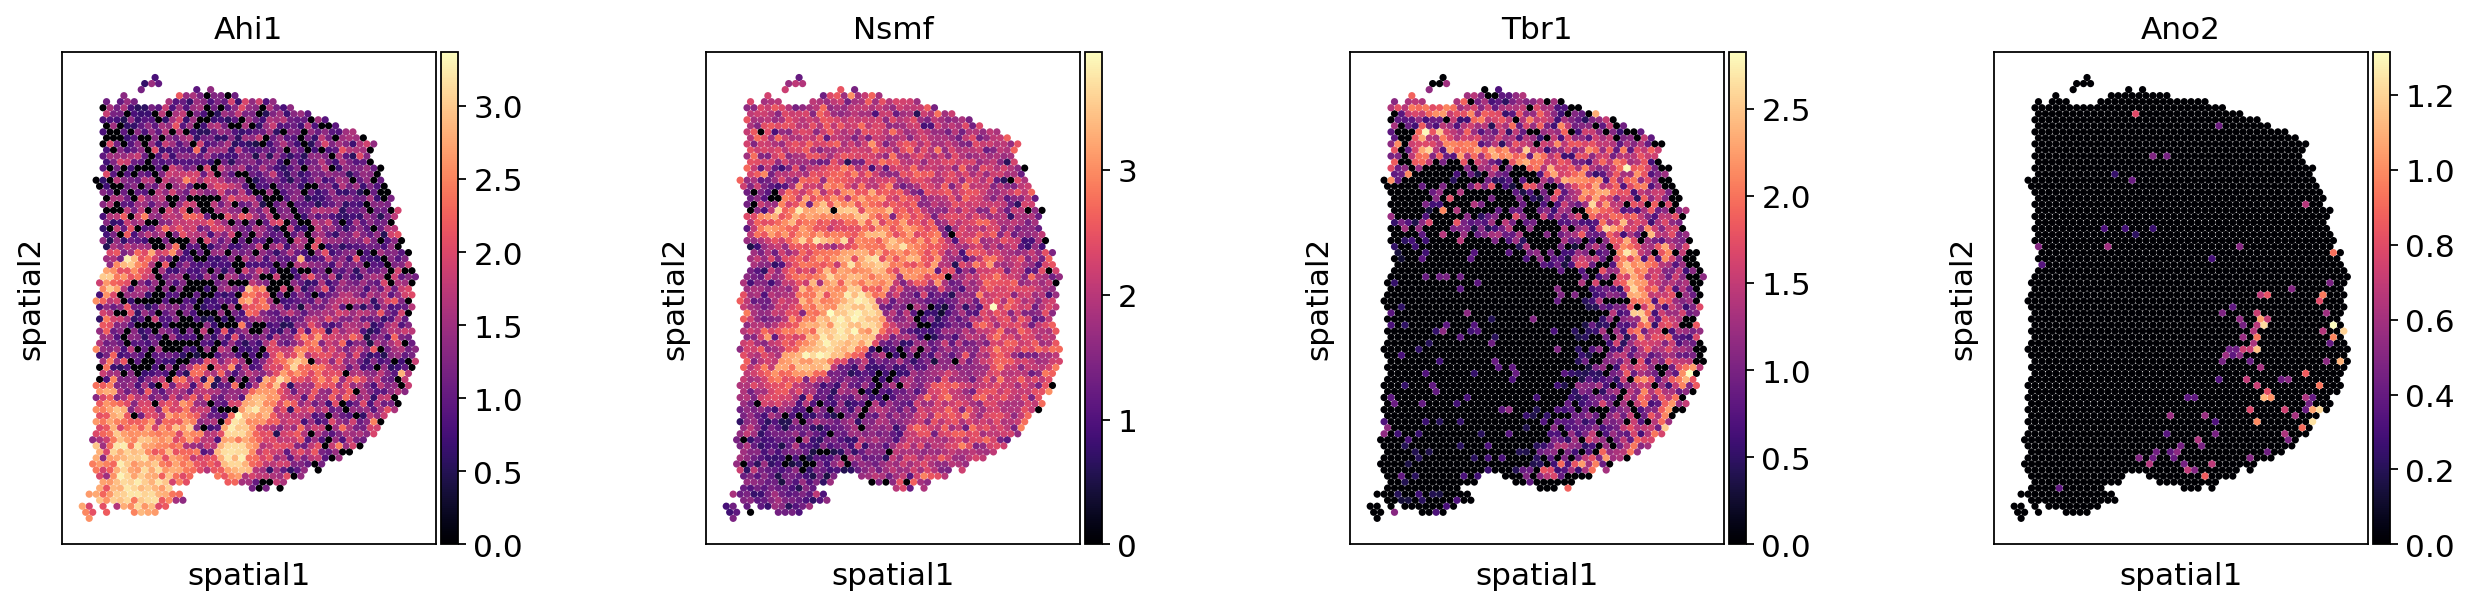

In [12]:
# Before enhancement
sc.pl.spatial(adata, color=plot_svgs[:4], img_key=None, size=1.6, cmap='magma', use_raw=False)

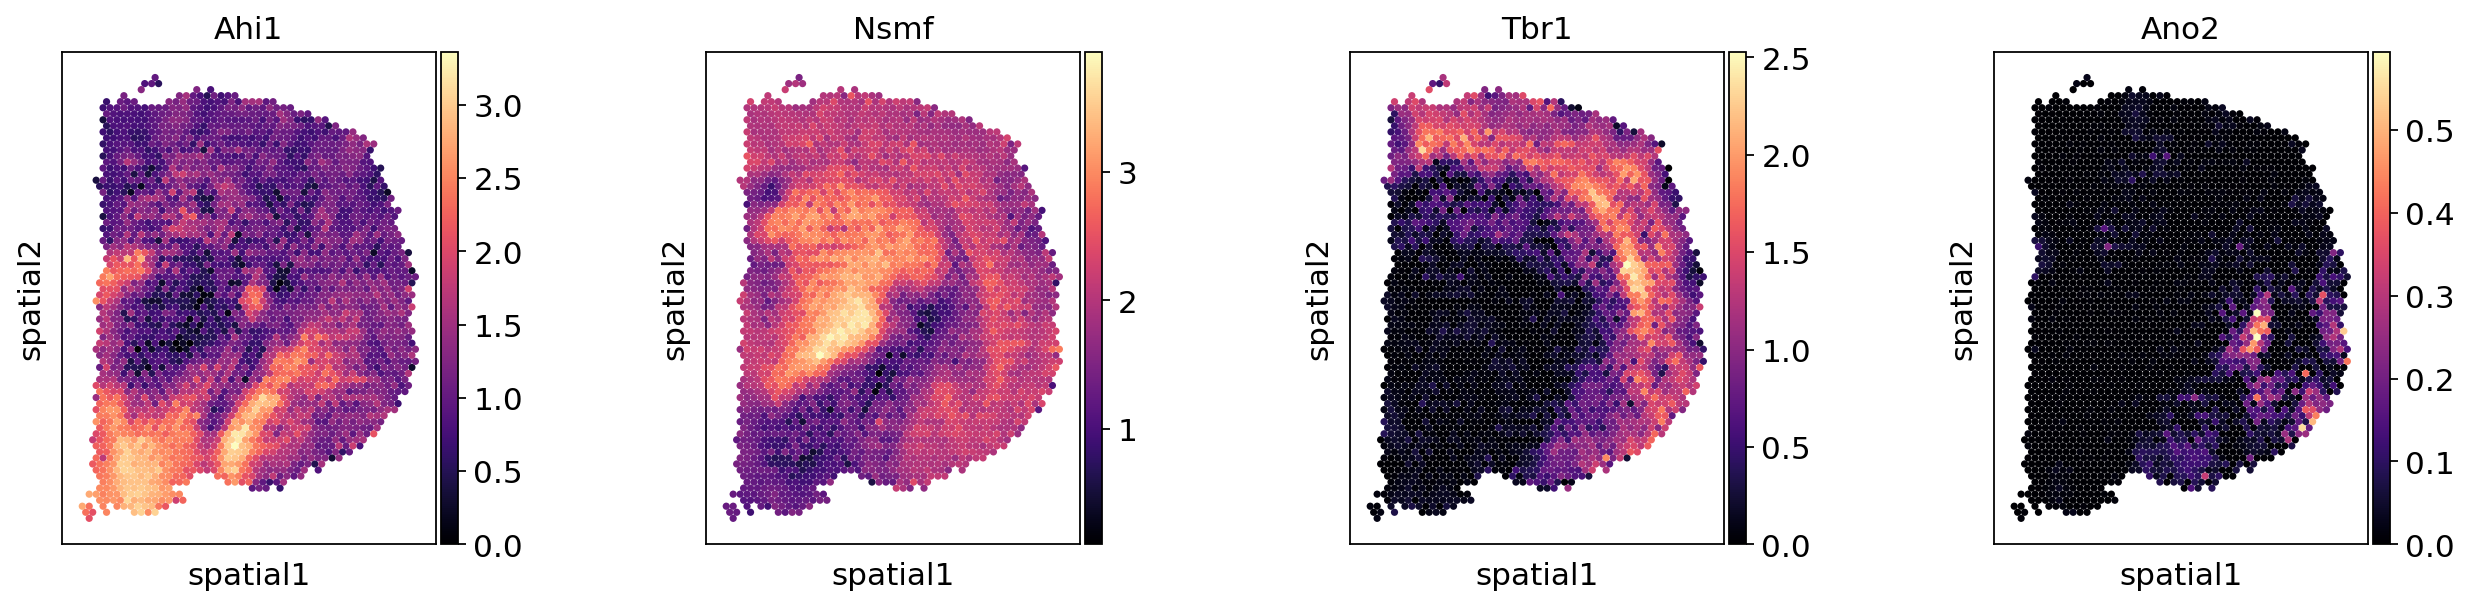

In [13]:
# After enhancement
sc.pl.spatial(new_adata, color=plot_svgs[:4], img_key=None, size=1.6, cmap='magma', use_raw=False)